In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 999)
import timeit

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('Fire_Dep_Call_50%.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (19,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
cols = ['Available DtTm', 'Response DtTm', 'Dispatch DtTm', 'Received DtTm']
for col in cols:
    df[col] = pd.to_datetime(df[col], format='%m/%d/%Y %I:%M:%S %p', infer_datetime_format=True)

df['Respond to Available'] = df['Available DtTm'] - df['Response DtTm']
df['Call to Dispatch'] = df['Dispatch DtTm'] - df['Received DtTm']

time_cols = ['Respond to Available', 'Call to Dispatch']
df[time_cols] = df[time_cols].applymap(lambda t: t.total_seconds())
df[time_cols] = df[time_cols].applymap(lambda x: max(x,0))

In [5]:
df['Month'] = df['Received DtTm'].dt.month
df['WeekDay'] = df['Received DtTm'].dt.weekday
df['Weekofyear'] = df['Received DtTm'].dt.weekofyear
df['Hours'] = df['Received DtTm'].dt.hour
df['Minutes'] = df['Received DtTm'].dt.minute

#---------added----------columns for hospital or transport
df['Hospital or Transport'] = (~(df['Transport DtTm'].isna() & df['Hospital DtTm'].isna())).astype('int')

def fill_na(df):
    q = df['Original Priority'].value_counts(normalize=True) #counts share of valeus in col w/o N/A
    orig_prio_list = q.index.tolist()  #makes indeces(priorities types) to a list
    orig_prio_shares = q.tolist() #makes values of shares a list
    df['Original Priority'] = df['Original Priority'].fillna(pd.Series(np.random.choice(orig_prio_list, p=orig_prio_shares, size=len(df))))

    w = df['Call Type Group'].value_counts(normalize=True) #counts share of values in col w/o N/A
    call_types_list = w.index.tolist()  #makes indeces(priorities types) to a list
    call_types_shares = w.tolist() #makes values of shares a list
    df['Call Type Group'] = df['Call Type Group'].fillna(pd.Series(np.random.choice(call_types_list, p=call_types_shares, size=len(df))))
    
fill_na(df)

if((df['Zipcode of Incident'].nunique()) <= (df['Neighborhooods - Analysis Boundaries'].nunique())):
    zipcodes = df[['Neighborhooods - Analysis Boundaries','Zipcode of Incident']]
    zipcodes = zipcodes[zipcodes['Zipcode of Incident'].notnull()]
    zips= list(zipcodes['Zipcode of Incident'].values)
    nbhds= list(zipcodes['Neighborhooods - Analysis Boundaries'].values)
    if len(zips) == len(nbhds):
        zipcodes_dict=dict(zip(nbhds,zips))

    else: 
        print('Count unique zipcodes != count neighborhooods, something went wrong.')
else:
    print('More zipcodes than neighborhooods, we need new strategy!')

df['Zipcode of Incident'] = df['Zipcode of Incident'].fillna(df['Neighborhooods - Analysis Boundaries'].map(zipcodes_dict))
df['Zipcode of Incident'] = df['Zipcode of Incident'].astype(int)

In [6]:
#only not null, not zero and less that 10 hours to solve
df1 = df[(df['Respond to Available'].notnull()) & (df['Respond to Available'] <= 36000) & (df['Respond to Available']!=0)]

In [7]:
df1 = df1.drop(columns=['Call Number','Unit ID', 'Incident Number', 'Call Type Group', 'Call Date', 'Watch Date', 
                      'Received DtTm', 'Entry DtTm', 'Dispatch DtTm','Response DtTm', 'On Scene DtTm',
                      'Transport DtTm','Hospital DtTm', 'Call Final Disposition', 'Available DtTm', 'Minutes',
                      'Supervisor District', 'Neighborhooods - Analysis Boundaries', 'Original Priority','Station Area',
                      'Address', 'City', 'Priority', 'Final Priority',  'Location', 'Month', 'WeekDay', 'Weekofyear',  
                      'RowID', 'Battalion', 'ALS Unit', 'Fire Prevention District'], errors='ignore')

df1 = df1.dropna(how='any') 

In [8]:
dum_list = ['Unit Type', 'Call Type']

for col in dum_list:
    dummies = pd.get_dummies(df1[col], prefix=col, drop_first=True)
    df1[dummies.columns]= dummies

In [9]:
df1= df1.drop(columns=['Unit Type', 'Call Type'])

In [10]:
y = df1['Respond to Available']
X = df1.drop(columns=['Respond to Available'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

## DECISION TREES

In [2]:
from sklearn.tree import DecisionTreeRegressor

In [53]:
#for depth=2
start_time = timeit.default_timer()

dtr_2 = DecisionTreeRegressor(max_depth=2)
dtr_2.fit(X_train, y_train)

elapsed = timeit.default_timer() - start_time 
print('It took:'+ str(elapsed) + ' seconds to run it.')

It took:2.6017341900151223 seconds to run it.


In [71]:
dtr_2.get_params

<bound method BaseEstimator.get_params of DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')>

In [54]:
dtr_2.score(X_test, y_test)

0.5839925072201977

In [55]:
y_pred_dtr_2 = dtr_2.predict(X_test)
mean_absolute_error(y_test, y_pred_dtr_2)

669.8034541797589

In [57]:
mean_squared_error(y_test, y_pred_dtr_2)

1186187.5029670226

In [59]:
mean_squared_error(y_test, y_pred_dtr_2)**0.5

1089.1223544519792

In [60]:
dtr_2.feature_importances_

array([0.        , 0.        , 0.14846578, 0.        , 0.        ,
       0.        , 0.83260644, 0.        , 0.01892778, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

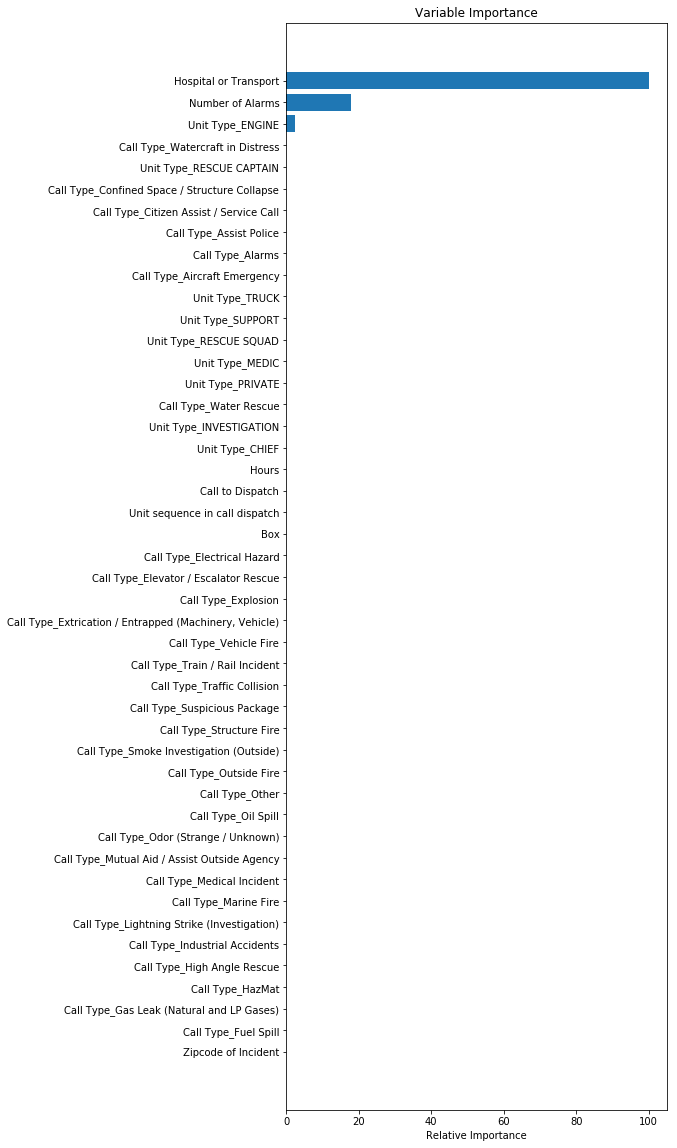

In [61]:
feature_importance_DT2 = dtr_2.feature_importances_
feature_importance_DT2 = 100.0 * (feature_importance_DT2/ feature_importance_DT2.max())
sorted_idx = np.argsort(feature_importance_DT2)
plt.figure(figsize=(15,20))
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance_DT2[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [62]:
#for depth=7, 100 performed very bad
start_time = timeit.default_timer()

dtr_7 = DecisionTreeRegressor(max_depth=7)
dtr_7.fit(X_train, y_train)

elapsed = timeit.default_timer() - start_time 
print('It took:'+ str(elapsed) + ' seconds to run it.')

It took:7.239684773841873 seconds to run it.


In [72]:
dtr_7.get_params

<bound method BaseEstimator.get_params of DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')>

In [63]:
dtr_7.score(X_test, y_test)

0.6091348179523037

In [64]:
y_pred_dtr_7 = dtr_7.predict(X_test)
mean_absolute_error(y_test, y_pred_dtr_7)

637.2733976881318

In [65]:
mean_squared_error(y_test, y_pred_dtr_7)

1114497.7009712595

In [66]:
mean_squared_error(y_test, y_pred_dtr_7)**0.5

1055.6977318206473

In [73]:
dtr_7.feature_importances_

array([3.73991818e-03, 2.03044338e-02, 1.48962165e-01, 1.33014398e-02,
       8.17832098e-03, 4.12616790e-03, 7.48903327e-01, 1.48763554e-03,
       1.70249466e-02, 1.06260377e-02, 6.86474155e-03, 1.99364824e-04,
       2.09073331e-03, 4.68690730e-04, 1.93715219e-03, 9.01038402e-03,
       0.00000000e+00, 2.80321135e-05, 3.52378414e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.46178877e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.80899111e-04, 0.00000000e+00, 0.00000000e+00, 1.50648544e-03,
       0.00000000e+00, 2.60567430e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

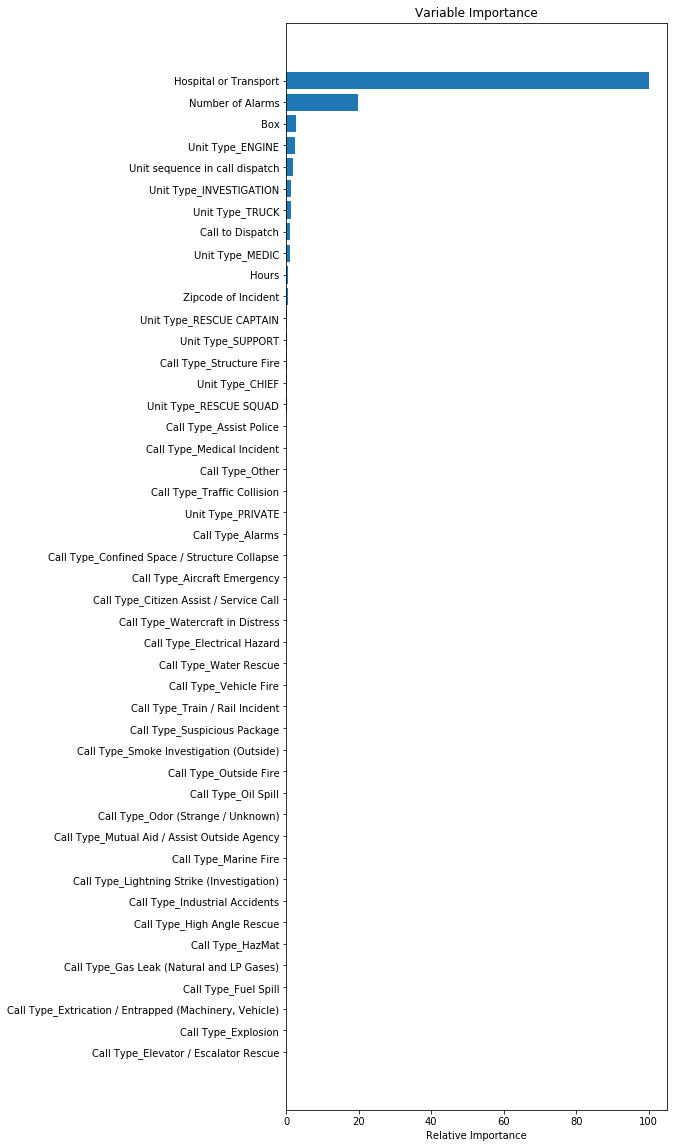

In [74]:
feature_importance_DT7 = dtr_7.feature_importances_
feature_importance_DT7 = 100.0 * (feature_importance_DT7/ feature_importance_DT7.max())
sorted_idx = np.argsort(feature_importance_DT7)
plt.figure(figsize=(15,20))
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance_DT7[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [75]:
max_depths = [5,10,15,20]
start_time = timeit.default_timer()

for max_depth in max_depths:
    dtr_multi = DecisionTreeRegressor(max_depth=max_depth)
    dtr_multi.fit(X_train, y_train)
    y_pred = dtr_7.predict(X_test)
    score = dtr_multi.score(X_test, y_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)**0.5
    print('Max depth = '+ str(max_depth))
    print('score is: '+ str(score))
    print('MAE: '+ str(mae))
    print('mse: '+ str(mse))
    print('mse: '+ str(rmse))
elapsed = timeit.default_timer() - start_time 
print('It took:'+ str(elapsed) + ' seconds to run it.')

Max depth = 5
score is: 0.6025383875420411
MAE: 637.2733976881318
mse: 1114497.7009712595
mse: 1055.6977318206473
Max depth = 10
score is: 0.6116402071942844
MAE: 637.2733976881318
mse: 1114497.7009712595
mse: 1055.6977318206473
Max depth = 15
score is: 0.5993361891682429
MAE: 637.2733976881318
mse: 1114497.7009712595
mse: 1055.6977318206473
Max depth = 20
score is: 0.5640477566800426
MAE: 637.2733976881318
mse: 1114497.7009712595
mse: 1055.6977318206473
It took:44.686920799082145 seconds to run it.


In [79]:
max_depths = [8,9,10,11]
start_time = timeit.default_timer()
for max_depth in max_depths:
    dtr_multi = DecisionTreeRegressor(max_depth=max_depth, splitter='best')
    dtr_multi.fit(X_train, y_train)
    y_pred = dtr_multi.predict(X_test)
    score = dtr_multi.score(X_test, y_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)**0.5
    print('Max depth = '+ str(max_depth))
    print('score is: '+ str(score))
    print('MAE: '+ str(mae))
    print('mse: '+ str(mse))
    print('rmse: '+ str(rmse))
    print('-----------')
elapsed = timeit.default_timer() - start_time 
print('It took:'+ str(elapsed) + ' seconds to run it.')

Max depth = 8
score is: 0.6115506508341662
MAE: 634.2870517515915
mse: 1107609.2895280581
rmse: 1052.4301827333052
-----------
Max depth = 9
score is: 0.6127490618334475
MAE: 630.6403262314911
mse: 1104192.1872512049
rmse: 1050.8054944903956
-----------
Max depth = 10
score is: 0.6114581106200279
MAE: 631.7287560881052
mse: 1107873.1550772076
rmse: 1052.555535388612
-----------
Max depth = 11
score is: 0.6117537089291232
MAE: 626.4346160208452
mse: 1107030.2976137418
rmse: 1052.1550729876951
-----------
It took:42.67061481298879 seconds to run it.


In [80]:
max_depths = [8,9,10,11]
start_time = timeit.default_timer()
for max_depth in max_depths:
    dtr_multi = DecisionTreeRegressor(max_depth=max_depth, splitter='random')
    dtr_multi.fit(X_train, y_train)
    y_pred = dtr_multi.predict(X_test)
    score = dtr_multi.score(X_test, y_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)**0.5
    print('Max depth = '+ str(max_depth))
    print('score is: '+ str(score))
    print('MAE: '+ str(mae))
    print('mse: '+ str(mse))
    print('rmse: '+ str(rmse))
    print('-----------')
elapsed = timeit.default_timer() - start_time 
print('It took:'+ str(elapsed) + ' seconds to run it.')

Max depth = 8
score is: 0.6079234051919429
MAE: 645.7639470369242
mse: 1117951.8759614094
rmse: 1057.3324339872534
-----------
Max depth = 9
score is: 0.6067882493432059
MAE: 646.6908105012162
mse: 1121188.6149746762
rmse: 1058.8619433026556
-----------
Max depth = 10
score is: 0.6119923030345584
MAE: 640.1610867029592
mse: 1106349.9797082695
rmse: 1051.8317259468215
-----------
Max depth = 11
score is: 0.6101888251373827
MAE: 639.1996213626926
mse: 1111492.3460854045
rmse: 1054.273373506798
-----------
It took:30.93845524615608 seconds to run it.


In [81]:
dtr_zero = DecisionTreeRegressor()
dtr_zero.fit(X_train, y_train)
y_pred = dtr_zero.predict(X_test)
score_zero = dtr_zero.score(X_test, y_test)
mae_zero = mean_absolute_error(y_test, y_pred)
mse_zero = mean_squared_error(y_test, y_pred)
rmse_zero = mean_squared_error(y_test, y_pred)**0.5
print('score is: '+ str(score_zero))
print('MAE: '+ str(mae_zero))
print('mse: '+ str(mse_zero))
print('rmse: '+ str(rmse_zero))
print('-----------')

score is: 0.24099446781989242
MAE: 877.6753172385894
mse: 2164198.7045445587
rmse: 1471.1215804768003
-----------


In [83]:
min_samples_leaves = [1,2,3,4,5]
start_time = timeit.default_timer()
for min_samples_leaf in min_samples_leaves:
    dtr_multi = DecisionTreeRegressor(max_depth=11,min_samples_leaf=min_samples_leaf)
    dtr_multi.fit(X_train, y_train)
    y_pred = dtr_multi.predict(X_test)
    score = dtr_multi.score(X_test, y_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)**0.5
    print('Max depth = '+ str(11))
    print('min_smaple_leaves = '+ str(min_samples_leaf))
    print('score is: '+ str(score))
    print('MAE: '+ str(mae))
    print('mse: '+ str(mse))
    print('rmse: '+ str(rmse))
    print('-----------')
elapsed = timeit.default_timer() - start_time 
print('It took:'+ str(elapsed) + ' seconds to run it.')

Max depth = 11
min_smaple_leaves = 1
score is: 0.612487262298323
MAE: 626.287475468587
mse: 1104938.6722117816
rmse: 1051.1606310225766
-----------
Max depth = 11
min_smaple_leaves = 2
score is: 0.6141397810155549
MAE: 626.1510828275684
mse: 1100226.7449392667
rmse: 1048.9169390086456
-----------
Max depth = 11
min_smaple_leaves = 3
score is: 0.6133927439697204
MAE: 626.1950157919465
mse: 1102356.8171696998
rmse: 1049.9318154859866
-----------
Max depth = 11
min_smaple_leaves = 4
score is: 0.6138537430821642
MAE: 626.1023366334181
mse: 1101042.3423211682
rmse: 1049.3056477124137
-----------
Max depth = 11
min_smaple_leaves = 5
score is: 0.6159237599765142
MAE: 625.8548188243279
mse: 1095139.977066636
rmse: 1046.4893583150456
-----------
It took:51.515954388072714 seconds to run it.


In [84]:
min_samples_leaves = [5,6,7,8,15]
start_time = timeit.default_timer()
for min_samples_leaf in min_samples_leaves:
    dtr_multi = DecisionTreeRegressor(max_depth=11,min_samples_leaf=min_samples_leaf)
    dtr_multi.fit(X_train, y_train)
    y_pred = dtr_multi.predict(X_test)
    score = dtr_multi.score(X_test, y_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)**0.5
    print('Max depth = '+ str(11))
    print('min_smaple_leaves = '+ str(min_samples_leaf))
    print('score is: '+ str(score))
    print('MAE: '+ str(mae))
    print('mse: '+ str(mse))
    print('rmse: '+ str(rmse))
    print('-----------')
elapsed = timeit.default_timer() - start_time 
print('It took:'+ str(elapsed) + ' seconds to run it.')

Max depth = 11
min_smaple_leaves = 5
score is: 0.6159563538558825
MAE: 625.8116274148591
mse: 1095047.0401531165
rmse: 1046.4449532360106
-----------
Max depth = 11
min_smaple_leaves = 6
score is: 0.6162251936245877
MAE: 625.7697371589777
mse: 1094280.4809457143
rmse: 1046.0786208243214
-----------
Max depth = 11
min_smaple_leaves = 7
score is: 0.6165153034194599
MAE: 625.7498323974615
mse: 1093453.2732171556
rmse: 1045.6831610087042
-----------
Max depth = 11
min_smaple_leaves = 8
score is: 0.6174602487768748
MAE: 625.5733714966354
mse: 1090758.8929634194
rmse: 1044.3940314667732
-----------
Max depth = 11
min_smaple_leaves = 15
score is: 0.6169620586000101
MAE: 625.8308350295479
mse: 1092179.4129592231
rmse: 1045.0738791871238
-----------
It took:51.856654215138406 seconds to run it.


In [85]:
min_samples_leaves = [8,9,10,11,12]
start_time = timeit.default_timer()
for min_samples_leaf in min_samples_leaves:
    dtr_multi = DecisionTreeRegressor(max_depth=11,min_samples_leaf=min_samples_leaf)
    dtr_multi.fit(X_train, y_train)
    y_pred = dtr_multi.predict(X_test)
    score = dtr_multi.score(X_test, y_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)**0.5
    print('Max depth = '+ str(11))
    print('min_smaple_leaves = '+ str(min_samples_leaf))
    print('score is: '+ str(score))
    print('MAE: '+ str(mae))
    print('mse: '+ str(mse))
    print('rmse: '+ str(rmse))
    print('-----------')
elapsed = timeit.default_timer() - start_time 
print('It took:'+ str(elapsed) + ' seconds to run it.')

Max depth = 11
min_smaple_leaves = 8
score is: 0.6173293966171702
MAE: 625.6229701235504
mse: 1091131.9996965236
rmse: 1044.5726397414992
-----------
Max depth = 11
min_smaple_leaves = 9
score is: 0.6172143807894737
MAE: 625.6398398201724
mse: 1091459.9513315898
rmse: 1044.7296068034016
-----------
Max depth = 11
min_smaple_leaves = 10
score is: 0.6167962890324254
MAE: 625.8375679075559
mse: 1092652.0818242168
rmse: 1045.2999960892646
-----------
Max depth = 11
min_smaple_leaves = 11
score is: 0.6176551517740885
MAE: 625.6846846848101
mse: 1090203.1541760224
rmse: 1044.1279395629745
-----------
Max depth = 11
min_smaple_leaves = 12
score is: 0.6178027835214047
MAE: 625.6098202130067
mse: 1089782.202782725
rmse: 1043.9263397303112
-----------
It took:50.41298725293018 seconds to run it.


In [ ]:
BEST IS MAX DEPTH =11. min_sample_leaf = 12

In [3]:
dtr_multi = DecisionTreeRegressor(max_depth=11,min_samples_leaf=12)
dtr_multi.fit(X_train, y_train)
y_pred = dtr_multi.predict(X_test)
score = dtr_multi.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
print('Max depth = '+ str(11))
print('min_smaple_leaves = '+ str(min_samples_leaf))
print('score is: '+ str(score))
print('MAE: '+ str(mae))
print('mse: '+ str(mse))
print('rmse: '+ str(rmse))
print('-----------')

NameError: name 'X_train' is not defined